In [3]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import torch
import torch.nn as nn
import os
import math

In [4]:
sp500_data = pd.read_csv('SP500.csv')
print(sp500_data.head())

         Date         Open         High          Low        Close  \
0  2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990   
1  2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020   
2  2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015   
3  2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941   
4  2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980   

     Adj Close      Volume  
0  1132.989990  3991400000  
1  1136.520020  2491020000  
2  1137.140015  4972660000  
3  1141.689941  5270680000  
4  1144.979980  4389590000  


In [5]:
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])  # Convert Date column to datetime
price_history = {"^GSPC": sp500_data.set_index('Date')["Close"]}  # Set Date as the index for easy lookup

In [14]:
class stock:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history  = []
        self.long_position = 0
        self._long_history = np.zeros([0, 2]) #this keeps track of the amount of shares bought and at which prices. IF some shares are sold then they are removed from this list
        self.short_postion=0
        self._short_history = np.zeros([0,2]) #the opposite of long_history
        self.invested=0 #this is the amount of money invested in the stock
        self.realized_profit = 0.0 #this is accumulated profit from all transactions
        self.immediate_profit=0.0 #this is profit from the last transaction

    def _subtract_from_array(self, arr, X): #Used for removing shares from the history and calculating how much money was invested in those shares. Is useful for calculating profit of each transaction
        arr = np.array(arr, dtype=float)  # Ensure the array is a NumPy array and supports float operations
        cumulative_sum = np.cumsum(arr[:,0])  # Compute the cumulative sum of the array
        remaining = cumulative_sum - X   # Subtract X from the cumulative sum

        # print(arr,X)
        if remaining[-1]>0:
            # Find where the remaining amount becomes non-positive
            zeroed_indices = remaining <= 0
            #calculatenet money invested on the sold shares
            net_invested = arr[zeroed_indices,0].T@arr[zeroed_indices,1]
            # Update the array based on the remaining amount
            arr = arr[~zeroed_indices]
            net_invested+= (arr[0,0]-remaining[~zeroed_indices][0])*arr[0,1]
            arr[0,0] = remaining[~zeroed_indices][0]
        else:
            net_invested=arr[:,0].T@arr[:,1]
            arr=np.zeros([0, 2])
        # print(arr)
        return (arr,net_invested)
    
    def buy(self, date, amount):
        self.history.append((price_history[self.ticker][date], amount, +1))        
        shorted=min(self.short_postion, amount)
        bought=amount-shorted
        
        self.immediate_profit=0 # I reset this to 0 if no shares are shorted. So that when called from outside it tells no profit has been made or lost
        if shorted>0:
            self._short_history, net_borrowed = self._subtract_from_array(self._short_history, shorted) #remove the number of shorted shares from previous short history
            self.immediate_profit=net_borrowed - shorted * price_history[self.ticker][date]#profit from buying the shorted shares
            self.realized_profit += self.immediate_profit #accumulated profit
            self.short_postion -= shorted

        self._long_history=np.append(self._long_history,np.array([[bought,price_history[self.ticker][date]]]), axis=0) #append the new buy to the long history
        self.long_position += bought

        self.invested += amount * price_history[self.ticker][date] #shorted shares also count towards investing because they cancel out the negative sum we invested in the begining
        
    
    def sell(self, date, amount):
        self.history.append((price_history[self.ticker][date], amount, -1))
        long_sold = min(self.long_position, amount)
        shorted = amount - long_sold

        self.immediate_profit=0 # I reset this to 0 if no shares are shorted. So that when called from outside it tells no profit has been made or lost
        if long_sold > 0:
            self._long_history, net_invested = self._subtract_from_array(self._long_history, long_sold)  # Remove the number of sold shares from previous long history
            self.immediate_profit= long_sold * price_history[self.ticker][date] - net_invested  # Profit from selling the long shares
            self.realized_profit += self.immediate_profit #accumulated profit
            self.long_position -= long_sold

        self._short_history = np.append(self._short_history, np.array([[shorted, price_history[self.ticker][date]]]), axis=0)  # Append the new short to the short history
        self.short_postion += shorted

        self.invested -= amount * price_history[self.ticker][date] #invested amount can go negative if we are shorting as we are borrowing money.

    def close(self,date):
        if self.long_position > 0:
            self.sell(date, self.long_position)
        if self.short_postion > 0:  
            self.buy(date, self.short_postion)
        pass
    
    def unrealized_profit(self, date):
        # Calculate unrealized profit based on the current price and the invested amount
        current_price = price_history[self.ticker][date]
        profit = self._long_history[:,0].T@(current_price-self._long_history[:,1])
        profit += self._short_history[:,0].T@(self._short_history[:,1]-current_price)
        
        return profit

In [15]:
# Create a stock instance with a sample ticker
test_stock = stock("^GSPC")

# Define a test date and price
test_date = price_history["^GSPC"].index[0]  # Use the first date in price_history
test_price = price_history["^GSPC"][test_date]

# Perform a buy operation
test_stock.sell(test_date, 10)  # Buy 10 shares
print(test_stock.immediate_profit)

test_date2 = price_history["^GSPC"].index[1]  # Use the first date in price_history
test_stock.buy(test_date2, 5)  # Sell 5 shares
expected_profit = 5 * (price_history["^GSPC"][test_date2]-test_price)  # Expected profit from selling 5 shares
print(test_stock.immediate_profit, expected_profit)

test_date21 = price_history["^GSPC"].index[2]  # Use the first date in price_history
test_stock.sell(test_date21, 5)  # Sell 5 shares
expected_profit = 0
print(test_stock.immediate_profit, expected_profit)

test_date3 = price_history["^GSPC"].index[3]  # Use the first date in price_history
test_stock.buy(test_date3, 5)  # Sell 5 shares
expected_profit = 5 * (price_history["^GSPC"][test_date3]-test_price)  # Expected profit from selling 5 shares
print(test_stock.immediate_profit, expected_profit)

print(test_stock.realized_profit)

date5=price_history["^GSPC"].index[5]
test_stock.close(price_history["^GSPC"].index[5])
expected_profit = 5 * (price_history["^GSPC"][date5]-price_history["^GSPC"][test_date21])
print(test_stock.immediate_profit, expected_profit)

print(test_stock.realized_profit)
print("Test passed: .immediate_profit is working as expected.")


0
-17.650149999999485 17.650149999999485
0 0
-43.49975500000073 43.49975500000028
-61.14990500000022
-49.1998250000006 49.1998250000006
-110.34973000000082
Test passed: .immediate_profit is working as expected.


In [ ]:
class NNQ():
    def __init__(self,state_size):
        self.model = nn.Sequential(nn.Linear(state_size, 60), nn.ReLU(), nn.Linear(60, 20), nn.ReLU(), nn.Linear(20, 10), nn.ReLU(), nn.Linear(10, 5), nn.ReLU(), nn.Linear(5, 3)) #neural network takes 1 input and gives 3 output. Each output is for each actions
        self.target_model = nn.Sequential(nn.Linear(state_size, 60), nn.ReLU(), nn.Linear(60, 20), nn.ReLU(), nn.Linear(20, 10), nn.ReLU(), nn.Linear(10, 5), nn.ReLU(), nn.Linear(5, 3))
        self.target_model.load_state_dict(self.model.state_dict())  # Copy weights from self.model
        self.target_model.eval()  # Set the target model to evaluation mode
        self.optimizers = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.loss_fn=nn.MSELoss()
        self.actions=np.array([-1, 0, 1]) #-1 is sell, 0 is hold, 1 is buy
        self.loss_table=[]
    
    # def forward(self,s,a):
    #     s_torch = torch.tensor(s, dtype=torch.float32)
    #     i=np.where(self.actions==a)[0][0]
    #     output = self.models[i](s_torch)
    #     return output
    
    def get(self,s,a):
        i=np.where(self.actions==a)[0][0]
        s_torch = torch.tensor([s], dtype=torch.float32)
        # print("action=",a," i=",i,", state=",s_torch)
        return self.model(s_torch).detach().numpy().item(i)
    
    def target(self,data,discount):
        ans=np.zeros(len(data))
        for i in range(len(data)):
            s,a,r,s_prime=data[i]
            s_torch = torch.tensor([s_prime], dtype=torch.float32)
            max_q=np.max(self.target_model(s_torch).detach().numpy())
            ans[i]=r+discount*max_q
        return ans
    
    def update(self, data, epochs):
        t=self.target(data,0.9)
        self.model.train()
        for _ in range(epochs):
            i=0
            avg_loss=0  
            states = torch.tensor([s for (s, a, r, s_prime) in data], dtype=torch.float32)
            action_indices = [np.where(self.actions == a)[0][0] for (s, a, r, s_prime) in data]
            targets = torch.tensor(t, dtype=torch.float32)

            self.optimizers.zero_grad()
            predictions = self.model(states)[range(len(action_indices)), action_indices]
            loss = self.loss_fn(predictions, targets)
            loss.backward()
            self.optimizers.step()

            avg_loss = loss.item()
            self.loss_table.append(avg_loss)

            # for (s,a,r,s_prime) in data:
            #     i_a=np.where(self.actions==a)[0][0]
            #     s_torch = torch.tensor([s], dtype=torch.float32)
            #     self.optimizers.zero_grad()
            #     loss=self.loss_fn(self.model(s_torch)[0][i_a], torch.tensor([t[i]], dtype=torch.float32))
            #     loss.backward()
            #     self.optimizers.step()
            #     avg_loss+=loss.item()
            #     i+=1
            # avg_loss/=i
            # self.loss_table.append(avg_loss)
        print("average loss=",avg_loss)
        pass


In [17]:
def epsilon_greedy(q,s,eps):
    if np.random.rand()<eps:
        return np.random.choice([-1,0,1])
    else:
        q_values=[q.get(s,a) for a in [-1,0,1]]
        return np.argmax(q_values)-1

In [10]:
price_return = price_history["^GSPC"].pct_change().fillna(0)*100
# price_history["^GSPC"]['return'] = price_history["^GSPC"]['return']
price_return

Date
2010-01-04    0.000000
2010-01-05    0.311568
2010-01-06    0.054552
2010-01-07    0.400120
2010-01-08    0.288173
                ...   
2019-12-24   -0.019545
2019-12-26    0.512817
2019-12-27    0.003398
2019-12-30   -0.578082
2019-12-31    0.294602
Name: Close, Length: 2516, dtype: float64

In [11]:
price_return.iloc[2]

np.float64(0.05455205267743679)

In [18]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def getState(stk,data, t, n):    
    d = t - n + 1
    block = data.iloc[d:t + 1].values if d >= 0 else np.concatenate((np.full(-d, data.iloc[0]), data.iloc[0:t + 1].values))  # pad with t0
    res = np.array([block[i + 1] / block[i] - 1 for i in range(n - 1)])*100
    # res= np.array([sigmoid(block[i + 1]-block[i]) for i in range(n - 1)])
    feature1=(stk.long_position-stk.short_postion)/ 5 #number of stocks owned normalized by 30
    feature2=20*stk.unrealized_profit(price_return.index[t])/stk.invested if stk.invested!=0 else 0
    ans = np.concatenate((res, [feature1, feature2]))
    return ans
# print(getState(SP,price_history["^GSPC"],1,3))

In [19]:
Ndata=len(price_return)
#test-train split
Ntrain=int(Ndata*0.4)

In [21]:
window_size = 1
state_size = window_size + 2  # 2 for number of stocks and unrealized profit
Q = NNQ(state_size)
epochs = 20  # Define the number of epochs
capital=10000# amount of money available to invest

# Generate 1000 random samples of states
random_states = np.random.rand(1000, state_size) * 2 - 1

# Initialize a dictionary to store Q-values for each epoch
q_values_over_epochs = {action: [] for action in [-1, 0, 1]}
for action in [-1, 0, 1]:
        q_values_over_epochs[action].append(
            [Q.get(state, action) for state in random_states]
        )
for epoch in range(epochs):
    SP = stock("^GSPC")
    stock_history = []
    profit = []
    for i in range(Ntrain - 1):
        s = getState(SP,price_history["^GSPC"], i, window_size + 1)  # Get the state
        eps_decay = 0.1 + 0.9 * np.exp(-i / Ntrain * 1)  # Epsilon decay
        a = epsilon_greedy(Q, s, eps_decay)
        date = price_history["^GSPC"].index[i]
        if a == 1:
            SP.buy(date, 1)
            r = SP.immediate_profit-abs(SP.invested)/capital # I punish for investing a lof of money
            capital=capital+SP.immediate_profit
        elif a == -1:
            SP.sell(date, 1)
            r = SP.immediate_profit-abs(SP.invested)/capital # I punish for investing a lof of money
            capital=capital+SP.immediate_profit
        else:
            r = 0
        s_prime = getState(SP,price_history["^GSPC"], i + 1, window_size + 1) if i + 1 < Ntrain else 0
        stock_history.append((s, a, r, s_prime))
        if i % 10 == 0 and i > 0:
            if len(stock_history) > 30:
                update_history = stock_history[-30:]  # Take the last 30 samples
                Q.update(update_history, 20)
            else:
                Q.update(stock_history, 20)
            print(i, " ", SP.realized_profit, " ", a, r)
        profit.append(SP.realized_profit)
    SP.close(price_history["^GSPC"].index[i])
    print(f"Epoch {epoch + 1}/{epochs} - Realized profit: {SP.realized_profit}")
    # Update the target model after each epoch
    Q.target_model.load_state_dict(Q.model.state_dict())  # Copy weights from self.model
    Q.target_model.eval()  # Set the target model to evaluation mode

    # Compute Q-values for random states after this epoch
    for action in [-1, 0, 1]:
        q_values_over_epochs[action].append(
            [Q.get(state, action) for state in random_states]
        )

<ipython-input-16-521d75b2c62f>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  s_torch = torch.tensor([s], dtype=torch.float32)


average loss= 5.624889850616455
10   7.83996500000012   0 0
average loss= 218.59170532226562
20   -93.32995699999992   0 0
average loss= 118.57467651367188
30   -247.7800299999999   0 0
average loss= 136.6739959716797
40   -218.76013199999989   1 -0.24700550999717072
average loss= 171.51998901367188
50   -140.50024399999984   1 -0.36588673809791195
average loss= 52.69401550292969
60   -115.68029699999988   1 -0.3674102468476175
average loss= 35.19809341430664
70   -22.840332999999646   -1 41.757003679626585
average loss= 30.07769775390625
80   8.049682000000303   -1 -0.5074818894045376
average loss= 26.54191780090332
90   -76.95031999999946   0 0
average loss= 21.70683479309082
100   -184.01025599999957   -1 -0.09362782836664733
average loss= 46.39555740356445
110   -145.0601829999996   -1 -0.09604724235527033
average loss= 97.26168060302734
120   -129.3701189999997   0 0
average loss= 46.67715835571289
130   -108.13012899999967   0 0
average loss= 69.36170196533203
140   -133.22009499

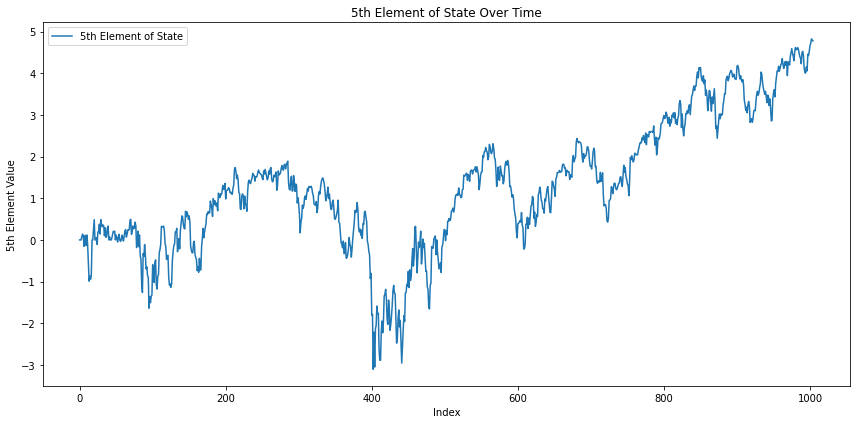

In [23]:
# Extract the 5th element of the state from stock_history
fifth_element = [state[0][2] for state in stock_history]

# Plot the 5th element
plt.figure(figsize=(12, 6))
plt.plot(fifth_element, label='5th Element of State')
plt.title('5th Element of State Over Time')
plt.xlabel('Index')
plt.ylabel('5th Element Value')
plt.legend()
plt.tight_layout()
plt.show()

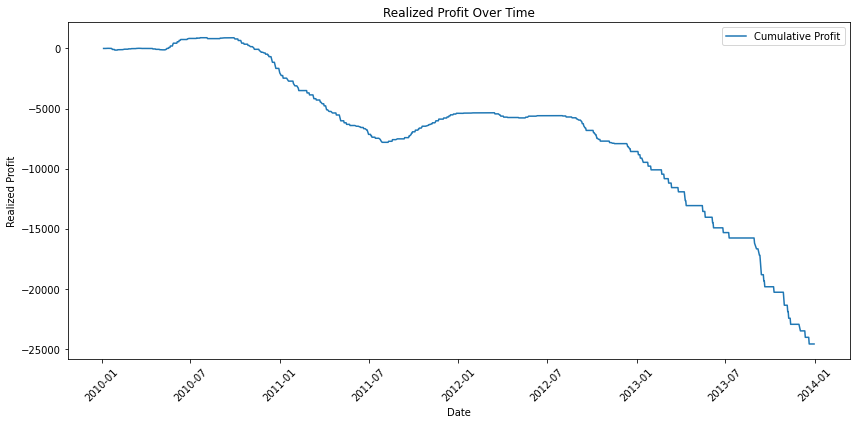

In [24]:
# Plotting the realized profit over time
plt.figure(figsize=(12, 6))
plt.plot(price_history["^GSPC"].index[:len(profit)], profit, label='Cumulative Profit')
plt.title('Realized Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Realized Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

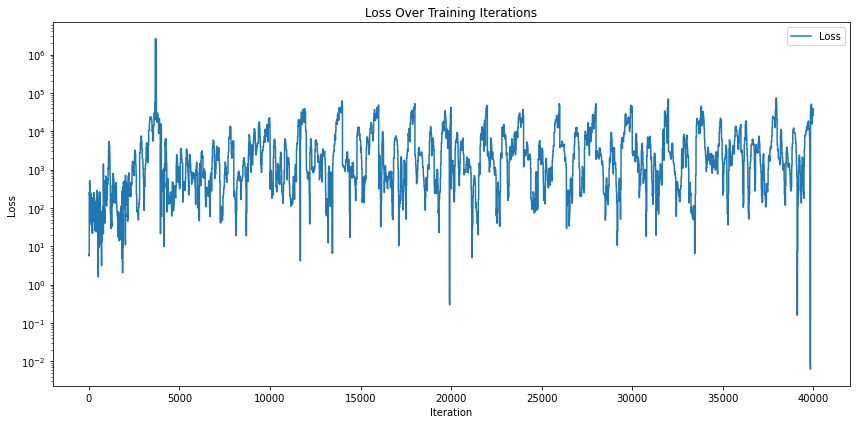

In [25]:
# Plotting the loss table
plt.figure(figsize=(12, 6))
plt.yscale('log')
plt.plot(Q.loss_table, label='Loss')
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


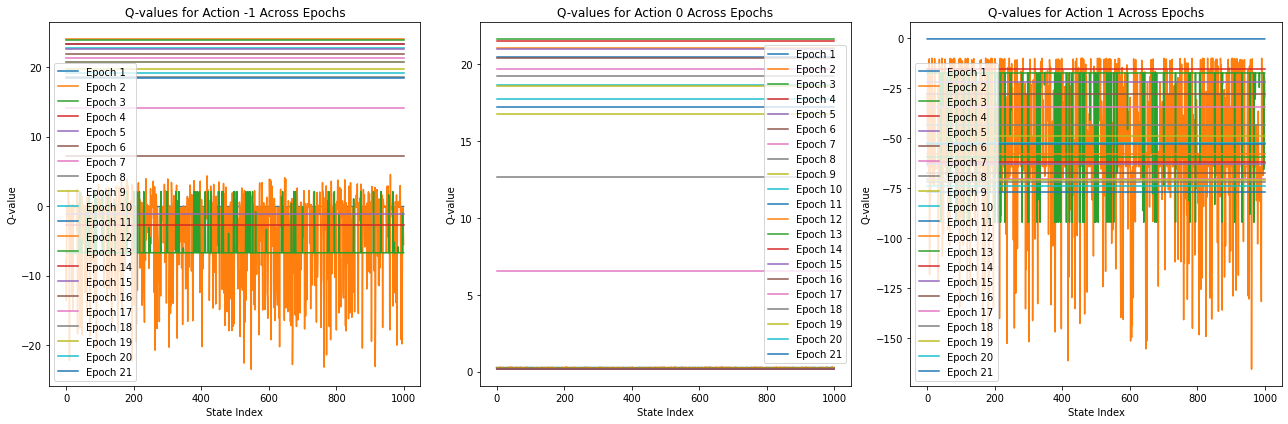

In [26]:
# Plot the Q-values for each action across epochs
plt.figure(figsize=(18, 6))

# Plot for action -1
plt.subplot(1, 3, 1)
for epoch, epoch_values in enumerate(q_values_over_epochs[-1]):
    plt.plot(range(len(epoch_values)), epoch_values, label=f'Epoch {epoch + 1}')
plt.title('Q-values for Action -1 Across Epochs')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()

# Plot for action 0
plt.subplot(1, 3, 2)
for epoch, epoch_values in enumerate(q_values_over_epochs[0]):
    plt.plot(range(len(epoch_values)), epoch_values, label=f'Epoch {epoch + 1}')
plt.title('Q-values for Action 0 Across Epochs')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()

# Plot for action 1
plt.subplot(1, 3, 3)
for epoch, epoch_values in enumerate(q_values_over_epochs[1]):
    plt.plot(range(len(epoch_values)), epoch_values, label=f'Epoch {epoch + 1}')
plt.title('Q-values for Action 1 Across Epochs')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()

plt.tight_layout()
plt.show()

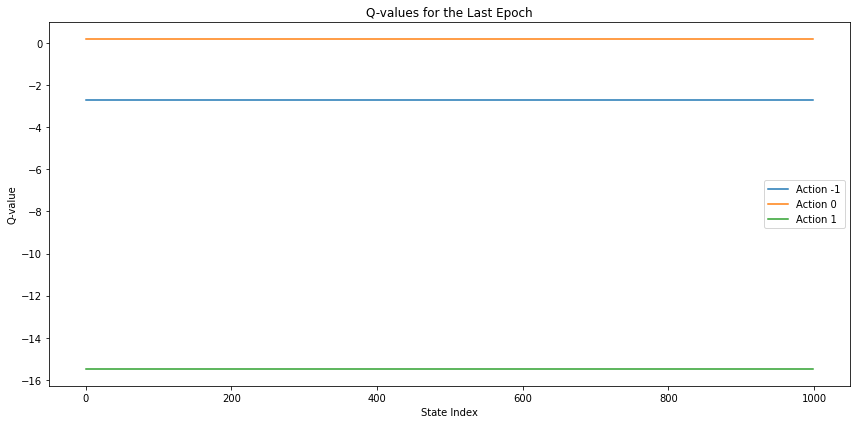

In [33]:
# Plot the Q-values for the last epoch
plt.figure(figsize=(12, 6))

epoch=3
for action in [-1, 0, 1]:
    plt.plot(range(len(q_values_over_epochs[action][epoch])), q_values_over_epochs[action][epoch], label=f'Action {action}')

plt.title('Q-values for the Last Epoch')
plt.xlabel('State Index')
plt.ylabel('Q-value')
plt.legend()
plt.tight_layout()
plt.show()

In [468]:
abs(np.array(q_values_over_epochs[1][-1])/np.array(q_values_over_epochs[0][-1]))>1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [386]:
indices = np.where((q_values_over_epochs[1][3]) > np.maximum(q_values_over_epochs[0][3], q_values_over_epochs[-1][3]))[0]
print(indices)

[]


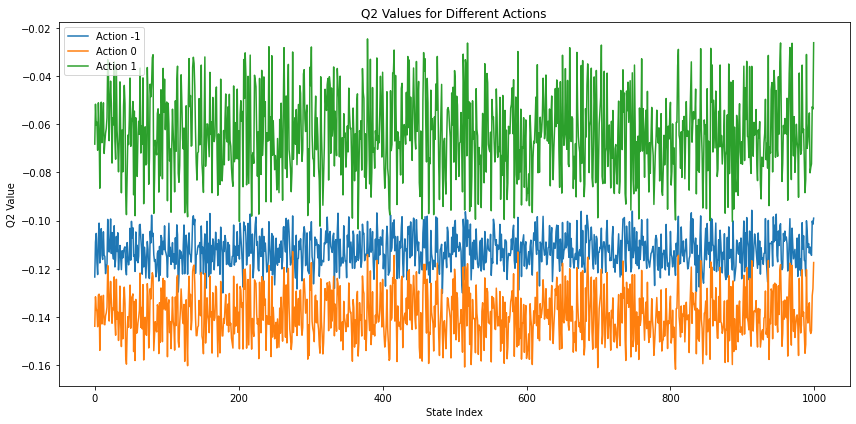

In [344]:
Q2=NNQ(5)
plt.figure(figsize=(12, 6))
for action in [-1, 0, 1]:
    q_values = [Q2.get(state, action) for state in random_states]
    plt.plot(range(len(random_states)), q_values, label=f'Action {action}')
plt.title('Q2 Values for Different Actions')
plt.xlabel('State Index')
plt.ylabel('Q2 Value')
plt.legend()
plt.tight_layout()
plt.show()

In [291]:
stock_history[73]

(array([0.99993558]),
 np.int64(1),
 np.float64(-56.660033999999996),
 array([0.2261634]))

In [292]:
(s,a,r,s_prime)=stock_history[73]
print("reward=",r)
t=Q.target(stock_history[73:74],0.9)
print("target=",t,"current=",Q.get(s,a))
print("initial Qs",Q.get(0,a),Q.get(1,a))
Q.update(stock_history[73:74],100)
print("target=",t,"current=",Q.get(s,a))
print("final Qs",Q.get(0,a),Q.get(1,a))

reward= -56.660033999999996
target= [74.36822528] current= 128.17184448242188
initial Qs 150.67718505859375 128.17041015625


/home/pranjal238/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


average loss= 23.752758026123047
target= [74.36822528] current= 79.10575866699219
final Qs 103.551513671875 79.10414123535156


In [286]:
Q.get(0.5,a)

139.42376708984375